In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, TensorBoard
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error 

In [5]:
data = pd.read_csv('all_data_results_cleaned.csv')

In [6]:
to_drop=["pipe_dn","pipe_schedule","flange_class",
         "support_right", "support_left"]
to_keep=["outside_diameter", "wall_thickness", "raised_face_depth",
        "w_neck_c", "flange_outer_radius", "flange_thickness_d","raised_face_radius",
        "length1", "length2", "lumped_mass", "frequency", "x_deformation_position",
        "y_deformation_position", "z_deformation_position", "support", "allowable_deformation"]

data.drop(columns=to_drop,inplace=True)

In [7]:
numeric_features = ["outside_diameter", "wall_thickness", "raised_face_depth" ,'length1', 'length2', 'lumped_mass',
                    "w_neck_c", "flange_outer_radius", "flange_thickness_d","raised_face_radius"]
categorical_features = ['support']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop=None), categorical_features)
    ])

In [8]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [9]:
output_columns = ['allowable_deformation', 'frequency', 'x_deformation_position', 'y_deformation_position', 'z_deformation_position']
x = data.drop(output_columns, axis=1)
y = pd.DataFrame(data[output_columns])

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [11]:
x_train_transformed = pipeline.fit_transform(x_train)
x_test_transformed = pipeline.transform(x_test)

In [12]:
scaler_y_frequency = StandardScaler()
scaler_y_allowable_deformation = StandardScaler()

y_train_transformed_frequency = scaler_y_frequency.fit_transform(pd.DataFrame(y_train["frequency"]))
y_test_transformed_frequency = scaler_y_frequency.transform(pd.DataFrame(y_test["frequency"]))

y_train_transformed_allowable_deformation = scaler_y_allowable_deformation.fit_transform(pd.DataFrame(y_train["allowable_deformation"]))
y_test_transformed_allowable_deformation = scaler_y_allowable_deformation.transform(pd.DataFrame(y_test["allowable_deformation"]))
"""
y_train_transformed_x_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["x_deformation_position"]))
y_test_transformed_x_displacement = scaler_y.transform(pd.DataFrame(y_test["x_deformation_position"]))

y_train_transformed_y_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["y_deformation_position"]))
y_test_transformed_y_displacement = scaler_y.transform(pd.DataFrame(y_test["y_deformation_position"]))

y_train_transformed_z_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["z_deformation_position"]))
y_test_transformed_z_displacement = scaler_y.transform(pd.DataFrame(y_test["z_deformation_position"]))
"""

'\ny_train_transformed_x_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["x_deformation_position"]))\ny_test_transformed_x_displacement = scaler_y.transform(pd.DataFrame(y_test["x_deformation_position"]))\n\ny_train_transformed_y_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["y_deformation_position"]))\ny_test_transformed_y_displacement = scaler_y.transform(pd.DataFrame(y_test["y_deformation_position"]))\n\ny_train_transformed_z_displacement = scaler_y.fit_transform(pd.DataFrame(y_train["z_deformation_position"]))\ny_test_transformed_z_displacement = scaler_y.transform(pd.DataFrame(y_test["z_deformation_position"]))\n'

In [13]:
logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

In [14]:
input_layer = Input(shape=(x_train_transformed.shape[1],))
hidden1 = Dense(512, activation='relu')(input_layer)
dropout1 = Dropout(0.2)(hidden1)
hidden2 = Dense(128, activation='relu')(dropout1)


# Separate output for each target variable
output_layer = Dense(1)(hidden2)
#, name='allowable_deformation'


In [15]:
model = Model(inputs=input_layer, outputs=output_layer)

In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,473 (287.00 KB)

 Trainable params: 73,473 (287.00 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='mse',
              metrics=["R2Score"])

In [18]:
history = model.fit(
    x_train_transformed, 
    y_train_transformed_frequency,  # Split the targets into separate arrays
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard_callback]
)

Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - R2Score: 0.6700 - loss: 0.2865 - val_R2Score: 0.8707 - val_loss: 0.1367
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - R2Score: 0.9025 - loss: 0.0966 - val_R2Score: 0.9302 - val_loss: 0.0738
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - R2Score: 0.9188 - loss: 0.0821 - val_R2Score: 0.9335 - val_loss: 0.0703
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - R2Score: 0.9346 - loss: 0.0652 - val_R2Score: 0.9582 - val_loss: 0.0441
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - R2Score: 0.9402 - loss: 0.0587 - val_R2Score: 0.9596 - val_loss: 0.0428
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - R2Score: 0.9533 - loss: 0.0476 - val_R2Score: 0.9624 - val_loss: 0.0397
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - R2Score: 0.9491 - loss: 0.0536 - val_R2Score: 0.9657 - val_loss: 0.0363
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - R2Score: 0.9469 - loss: 0.0511 - val_R2Score: 

In [19]:
test_loss, test_mse = model.evaluate(x_test_transformed, y_test_transformed_frequency)
print('Test accuracy:', test_mse)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - R2Score: 0.9931 - loss: 0.0061
Test accuracy: 0.9904049634933472


In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 14)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,421 (861.02 KB)

 Trainable params: 73,473 (287.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 146,948 (574.02 KB)

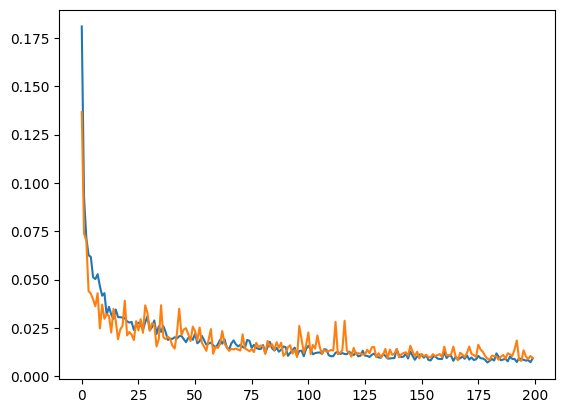

In [21]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")

In [22]:
predictions_scaled = model.predict(x_test_transformed)
predictions = scaler_y_frequency.inverse_transform((predictions_scaled))

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [23]:
predictions_df = pd.DataFrame(predictions)
print("\nSample Predictions:")
print(predictions_df.head())


Sample Predictions:
           0
0   8.814208
1   4.357087
2  15.530153
3   4.524933
4  21.355383


In [24]:
y_test["frequency"]

524        8.5656
4546       3.9866
6971      16.0461
10243      4.3495
7978      21.6986
           ...   
8768     129.0407
9224       2.2995
10168      6.5121
8959      28.7380
3188       1.0268
Name: frequency, Length: 2458, dtype: float64

In [25]:
true= y_test["frequency"].tolist()
pred= predictions_df[0].tolist()
mean_squared_error(true,pred)

4.747029898726121

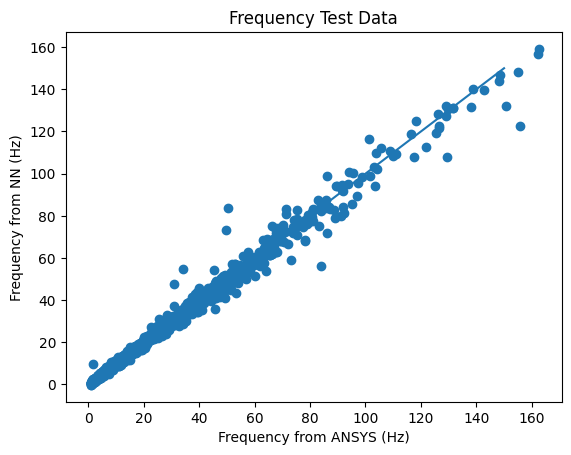

In [26]:
pred=predictions_df
true=y_test["frequency"]
plt.scatter(true,pred)
plt.plot([0, 150],[0, 150])
plt.xlabel("Frequency from ANSYS (Hz)")
plt.ylabel("Frequency from NN (Hz)")
plt.title("Frequency Test Data")
plt.show()

In [27]:
input_layer = Input(shape=(x_train_transformed.shape[1],))
hidden1 = Dense(256, activation='relu')(input_layer)
dropout1 = Dropout(0.2)(hidden1)
hidden2 = Dense(32, activation='relu')(dropout1)


# Separate output for each target variable
output_layer = Dense(1)(hidden2)
#, name='allowable_deformation'

In [28]:
model_d = Model(inputs=input_layer, outputs=output_layer)

In [29]:
model_d.compile(optimizer=Adam(learning_rate=0.001), 
              loss='mse',
              metrics=["R2Score"])

In [30]:
history_d = model_d.fit(
    x_train_transformed, 
    y_train_transformed_allowable_deformation,  # Split the targets into separate arrays
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[tensorboard_callback]
)

Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - R2Score: 0.3885 - loss: 0.5489 - val_R2Score: 0.8874 - val_loss: 0.1082
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - R2Score: 0.8432 - loss: 0.1751 - val_R2Score: 0.9328 - val_loss: 0.0646
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - R2Score: 0.9019 - loss: 0.0956 - val_R2Score: 0.9417 - val_loss: 0.0560
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - R2Score: 0.9245 - loss: 0.0798 - val_R2Score: 0.9442 - val_loss: 0.0536
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - R2Score: 0.9294 - loss: 0.0653 - val_R2Score: 0.9560 - val_loss: 0.0423
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - R2Score: 0.9314 - loss: 0.0695 - val_R2Score: 0.9466 - val_loss: 0.0513
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - R2Score: 0.9391 - loss: 0.0598 - val_R2Score: 0.9613 - val_loss: 0.0372
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - R2Score: 0.9472 - loss: 0.0532 - val_R2Score: 0.9620 - v

In [31]:
test_loss, test_mse = model_d.evaluate(x_test_transformed, y_test_transformed_allowable_deformation)
print('Test accuracy:', test_mse)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - R2Score: 0.9655 - loss: 0.0308
Test accuracy: 0.9738021492958069


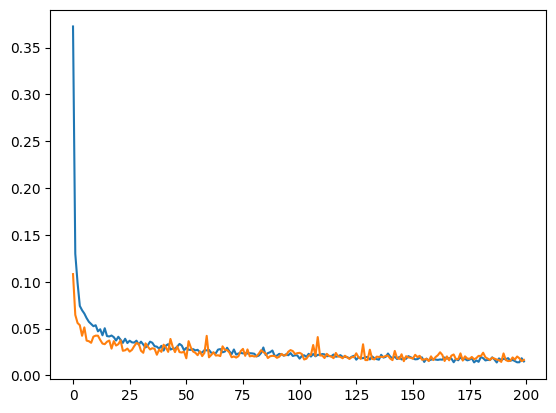

In [32]:
plt.plot(history_d.history["loss"],label="loss")
plt.plot(history_d.history["val_loss"],label="val_loss")

In [33]:
predictions_scaled_d = model_d.predict(x_test_transformed)
predictions_d = scaler_y_allowable_deformation.inverse_transform((predictions_scaled_d))

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [34]:
predictions_df_d = pd.DataFrame(predictions_d)
print("\nSample Predictions:")
print(predictions_df_d)


Sample Predictions:
               0
0       6.394835
1      85.288322
2      23.659307
3      13.924226
4       3.692662
...          ...
2453    3.795814
2454   22.219271
2455   14.248796
2456    1.830505
2457  614.004883

[2458 rows x 1 columns]


In [35]:
y_test["allowable_deformation"]

524        8.270
4546      84.443
6971      44.553
10243     15.073
7978       2.980
          ...   
8768       1.148
9224      22.090
10168     13.877
8959       1.573
3188     736.584
Name: allowable_deformation, Length: 2458, dtype: float64

In [36]:
true= y_test["allowable_deformation"].tolist()
pred_d= predictions_df_d[0].tolist()
mean_squared_error(true,pred_d)

165.55395447097783

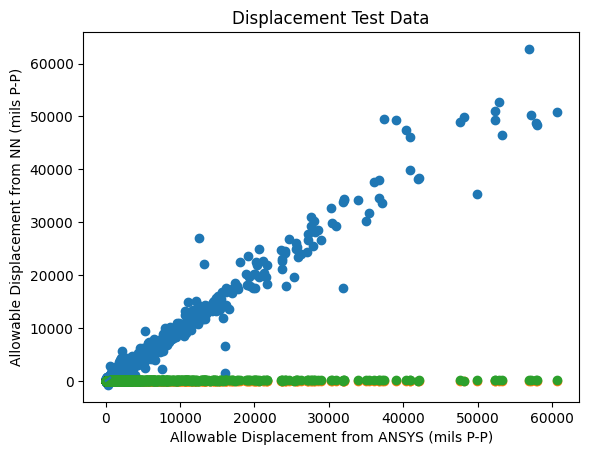

In [37]:
plot_NN_test_displacement_0P_mm=predictions_df_d
plot_NN_test_displacement_PP_mm = plot_NN_test_displacement_0P_mm*2
plot_NN_test_displacement_PP_mils = plot_NN_test_displacement_PP_mm/0.0254

plot_ANSYS_test_displacement_0P_mm = y_test["allowable_deformation"]
plot_ANSYS_test_displacement_PP_mm = plot_ANSYS_test_displacement_0P_mm*2
plot_ANSYS_test_displacement_PP_mils = plot_ANSYS_test_displacement_PP_mm/0.0254

plt.scatter(plot_ANSYS_test_displacement_PP_mils, plot_NN_test_displacement_PP_mils)
plt.plot([0, 600],[0, 600])



f=y_test["frequency"]
plot_EI_PROBLEM_velocity_RMS_mm = 10**((np.log10(f)+1.871083)/2.084547)
plot_EI_PROBLEM_velocity_PP_mm = plot_EI_PROBLEM_velocity_RMS_mm*(2**0.5)
plot_EI_PROBLEM_displacement_PP_mm = plot_EI_PROBLEM_velocity_PP_mm/(2*np.pi*f)
plot_EI_PROBLEM_displacement_PP_mils = plot_EI_PROBLEM_displacement_PP_mm/0.0254

plot_WACHEL_DANGER_dispalcement_PP_mils = (250/f)**0.5*10

plt.scatter(plot_ANSYS_test_displacement_PP_mils, plot_EI_PROBLEM_displacement_PP_mils)
plt.scatter(plot_ANSYS_test_displacement_PP_mils, plot_WACHEL_DANGER_dispalcement_PP_mils)


plt.xlabel("Allowable Displacement from ANSYS (mils P-P)")
plt.ylabel("Allowable Displacement from NN (mils P-P)")
plt.title("Displacement Test Data")

plt.show()

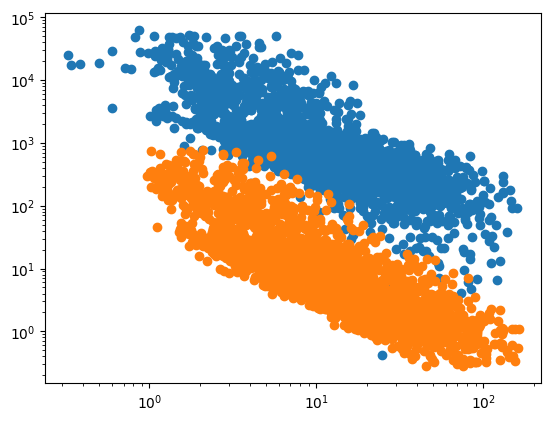

In [38]:
NN_displacement=plot_NN_test_displacement_PP_mils
NN_frequency=predictions_df
plt.scatter(NN_frequency,NN_displacement)
plt.loglog()
y=y_test["allowable_deformation"]
x=y_test["frequency"]
plt.scatter(x,y)
plt.show()

In [39]:
plot_linspace = np.linspace(0,200,10000)

plot_WACHEL_DESIGN_displacement_PP_mils = (250/plot_linspace)**0.5
plot_WACHEL_MARGINAL_displacement_PP_mils = plot_WACHEL_DESIGN_displacement_PP_mils*2
plot_WACHEL_CORRECTION_displacement_PP_mils = plot_WACHEL_DESIGN_displacement_PP_mils*4
plot_WACHEL_DANGER_displacement_PP_mils = plot_WACHEL_DESIGN_displacement_PP_mils*10

from inline_labels import add_inline_labels

C:\Users\austi\AppData\Local\Temp\ipykernel_21172\1672565149.py:3: RuntimeWarning: divide by zero encountered in divide
  plot_WACHEL_DESIGN_displacement_PP_mils = (250/plot_linspace)**0.5


Labels placement: 100%|#######################| 129/129 [00:03<00:00, 38.92it/s]
C:\Users\austi\AppData\Local\Temp\ipykernel_21172\2178849068.py:49: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


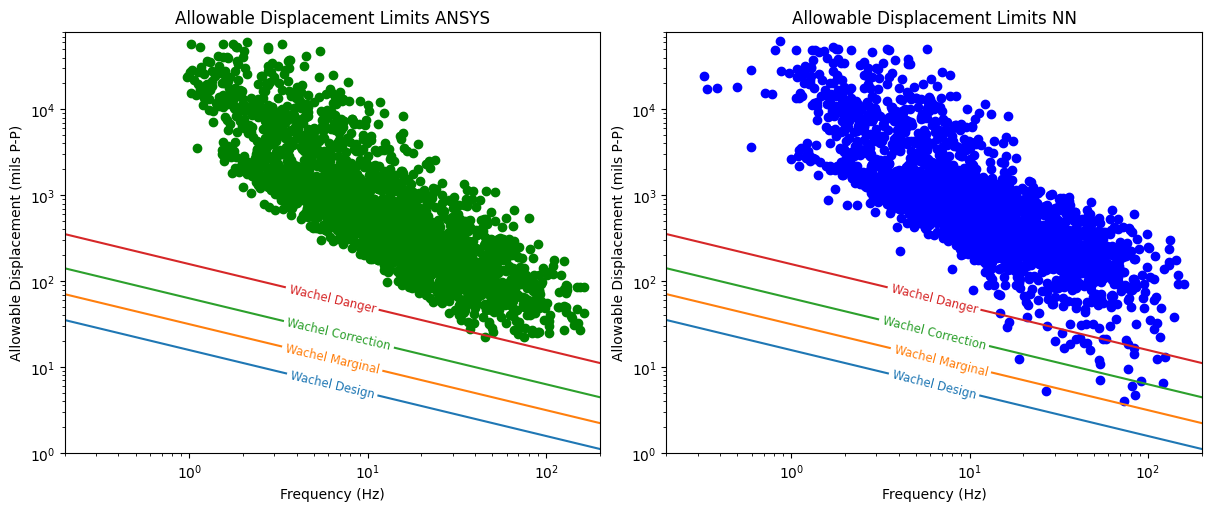

In [42]:
fig, axes = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(12, 5))
axes = axes.flatten()

ANSYS_dispalcement=y_test["allowable_deformation"]/0.0254*2
ANSYS_frequency=y_test["frequency"]

axes[0].scatter(ANSYS_frequency,ANSYS_dispalcement,c='g')


axes[0].plot(plot_linspace,plot_WACHEL_DESIGN_displacement_PP_mils, label='Wachel Design')
axes[0].plot(plot_linspace,plot_WACHEL_MARGINAL_displacement_PP_mils, label='Wachel Marginal')
axes[0].plot(plot_linspace,plot_WACHEL_CORRECTION_displacement_PP_mils, label='Wachel Correction')
axes[0].plot(plot_linspace,plot_WACHEL_DANGER_displacement_PP_mils, label='Wachel Danger')

axes[0].set_title('Allowable Displacement Limits ANSYS')
axes[0].set_xlim([0.2,200])
axes[0].set_ylim([1,80000])
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Allowable Displacement (mils P-P)')

axes[0].loglog()

add_inline_labels(axes[0], with_overall_progress=True, fontsize="small",debug=False)
"""handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(labels[0:4],markerscale=3)"""



axes[1].scatter(NN_frequency,NN_displacement,label="Fixed Fixed",c='b')


axes[1].plot(plot_linspace,plot_WACHEL_DESIGN_displacement_PP_mils, label='Wachel Design')
axes[1].plot(plot_linspace,plot_WACHEL_MARGINAL_displacement_PP_mils, label='Wachel Marginal')
axes[1].plot(plot_linspace,plot_WACHEL_CORRECTION_displacement_PP_mils, label='Wachel Correction')
axes[1].plot(plot_linspace,plot_WACHEL_DANGER_displacement_PP_mils, label='Wachel Danger')

axes[1].set_title('Allowable Displacement Limits NN')
axes[1].set_xlim([0.2,200])
axes[1].set_ylim([1,80000])
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Allowable Displacement (mils P-P)')

axes[1].loglog()

add_inline_labels(axes[1], with_overall_progress=True, fontsize="small",debug=False)
"""handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(labels[0:4],markerscale=3)"""

fig.show()